In [696]:
import numpy as np 
import pandas as pd 
import os
import cv2
from sklearn.svm import SVC
from skimage.feature import hog
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from skimage.color import rgb2gray
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.applications import VGG16
from skimage.feature import hog
from skimage import data, exposure
import random
from keras import layers, losses
from keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import keras 
from keras.layers import *
from keras.models import *
from keras import backend as K
from sklearn.metrics import classification_report, accuracy_score, matthews_corrcoef, confusion_matrix

In [697]:
#path martim
#path = "../../../../DadosProj/UTKFace/"
#path alex
path = "../../../data_project/UTKFace/"

files = os.listdir(path)
size = len(files)
print("Total samples:",size)
print(files[0])

Total samples: 23708
100_0_0_20170112213500903.jpg.chip.jpg


In [698]:
images = []
ages = []
genders = []

counter = 0

for file in files:
    if counter == 500:
        break
    
    image = cv2.imread(path+file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, dsize=(200, 200))
    image = image.reshape((image.shape[0], image.shape[1], 3)) ### A ausencia deste ponto  estava a causar o erro no ORB
    #image = image / 255.0 #normalizing values on each point 
    
    images.append(image)
    delimit = file.split('_')
    ages.append(int(delimit[0]))
    # first number is age (0-116 possible values)
    genders.append(int(delimit[1]))
    # second number is gender (0 for male, 1 for female)



    counter += 1

In [699]:
X = np.squeeze(images)
X.shape

(500, 200, 200, 3)

## Age Pre Process

In [702]:
age_classes = []
for i in ages:
    i = int(i)
    if i <= 1:
        age_classes.append(0)
    if (i>1) and (i<=13):
        age_classes.append(1)
    if (i>13) and (i<17):
        age_classes.append(2)
    if (i>=17) and (i<30):
        age_classes.append(3)
    if (i>=30) and (i<60):
        age_classes.append(4)
    if i>=60:
        age_classes.append(5)

In [703]:
age_labels =["Baby",   # index 0
        "Infant",      # index 1
        "Adolescent",  # index 2 
        "Young Adult", # index 3 
        "Adult"        #index 4
        "Old Adult",   # index 5
        ]

Gender Class: 0 Age Class: 1


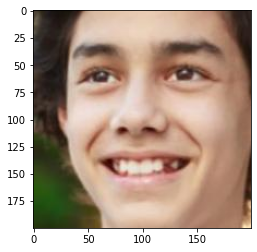

In [704]:
def display(img):
    plt.imshow(img)
    #plt.set_cmap('gray')
    plt.show()
idx = 100
sample = images[idx]
print("Gender Class:",genders[idx],"Age Class:",age_classes[idx])
display(sample)

Age Classes Distribution

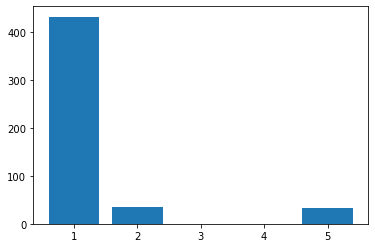

Max value: 5


In [705]:
x_ages = list(set(age_classes))
y_ages = [age_classes.count(i) for i in x_ages]
plt.bar(x_ages,y_ages)
plt.show()
print("Max value:",max(age_classes))

In [706]:
from keras.utils.np_utils import to_categorical
age_categories = to_categorical(age_classes, num_classes=6)
age_categories[:20]

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)

## Base CNN

### Age Classes

In [707]:
def split (x, y):
    X_train, X_test, y_train, y_test = train_test_split(X, age_categories, test_size=0.2,shuffle  = True)

In [708]:
def CNN (input_shape, loss, batch_size, epochs, output):
    model = tf.keras.Sequential()

    # Must define the input shape in the first layer of the neural network
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape = input_shape)) 
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(output, activation='softmax'))

    # Take a look at the model summary
    model.summary()

    model.compile(loss=loss,
                optimizer='adam',
                metrics=['accuracy'])
    
    history_base_age = model.fit(X_train, y_train,
         batch_size=batch_size,
         epochs=epochs,
         validation_data=(X_test, y_test),)

In [709]:
input_shape = (200,200,3)
loss = 'categorical_crossentropy'

CNN(input_shape, loss, 8, 2, 6)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_100 (Conv2D)         (None, 200, 200, 64)      832       
                                                                 
 max_pooling2d_84 (MaxPoolin  (None, 100, 100, 64)     0         
 g2D)                                                            
                                                                 
 dropout_83 (Dropout)        (None, 100, 100, 64)      0         
                                                                 
 conv2d_101 (Conv2D)         (None, 100, 100, 32)      8224      
                                                                 
 max_pooling2d_85 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                                                            
                                                                 
 dropout_84 (Dropout)        (None, 50, 50, 32)      

In [712]:
def cnn_metrics (X_test, y_test, classes):
    
"""    y_hat = model.predict(X_test)

    # Plot a random sample of 10 test images, their predicted labels and ground truth
    figure = plt.figure(figsize=(20, 8))
    for i, index in enumerate(np.random.choice(x_test.shape[0], size=15, replace=False)):
        ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
        # Display each image
        ax.imshow(np.squeeze(x_test[index]))
        predict_index = np.argmax(y_hat[index])
        #print(predict_index)
        true_index = np.argmax(y_test[index])
        #print(true_index)
        # Set the title for each image
        ax.set_title("{} ({})".format(labels[predict_index], 
                                    labels[true_index]),
                                    color=("green" if predict_index == true_index else "red"))"""
    
    preds = []
    truth = []
    y_hat = model.predict(X_test)

    for i in range(X_test.shape[0]):
        
        predict_index = np.argmax(y_hat[i])
        preds.append(predict_index) 
        
        true_index = np.argmax(y_test[i])
        truth.append(true_index)
        
    mcc = matthews_corrcoef(truth, preds)
    print("MCC: ", mcc)

    label = list(set(classes))

    cm = confusion_matrix(truth, preds)

    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=label, yticklabels=label)

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')

    plt.show()

    print(classification_report(truth, preds, target_names=label))

4/4 [==============================] - 1s 143ms/step


MCC:  0.03640487177027205


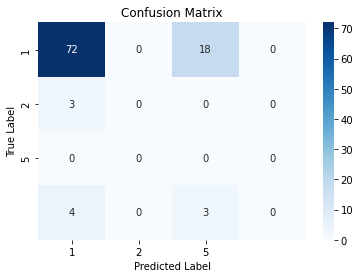

              precision    recall  f1-score   support

           1       0.91      0.80      0.85        90
           2       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         7

    accuracy                           0.72       100
   macro avg       0.23      0.20      0.21       100
weighted avg       0.82      0.72      0.77       100



In [717]:
cnn_metrics(X_test, y_test, age_classes)

### Gender

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, genders, test_size=0.2,shuffle  = True)
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [ ]:
history_base_gender = cnn.fit(X_train, y_train,
                    epochs=3,
                    batch_size=32,
                    validation_data=(X_test, y_test))

In [ ]:
preds = []
truth = []
y_hat = model.predict(X_test)

for i in range(X_test.shape[0]):
    
    predict_index = np.argmax(y_hat[i])
    preds.append(predict_index) 
    
    true_index = np.argmax(y_test[i])
    truth.append(true_index)


In [ ]:
mcc = matthews_corrcoef(truth, preds)
print("MCC: ", mcc)


label_age = list(set(classes))

# assume y_true and y_pred are the true and predicted labels, respectively
cm = confusion_matrix(truth, preds)

# create a heatmap of the confusion matrix using seaborn
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=label_age, yticklabels=label_age)

# set plot labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

plt.show()

In [ ]:
print(classification_report(truth, preds, target_names=labels))